# 1

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
root_dir = "/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/"

## Looking at the data

In [0]:
path = Path(f'{root_dir}images_filt'); path

PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt')

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/models'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/val')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path/'train/0')
fnames[:5]

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train/0/Jg6GdGV8RW.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train/0/LXP8A64Js3.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train/0/0E8Tn4h7k9.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train/0/a1GDdJ821s.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt/train/0/UXX4gkJuN0.png')]

In [0]:
np.random.seed(2)

In [0]:
!find /content/gdrive/My\ Drive/Colab\ Notebooks/LIP_DS/data/images/val  -type f | wc -l 

792


In [0]:
get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0, max_lighting=0.2, max_warp=0, p_affine=0, p_lighting=0.75)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [0]:
tfms = [RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={'change': 0.5659223670413377}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={'scale': 1.1426852134001517}, do_run=True, is_random=True)]

## Half res

In [0]:
data = ImageDataBunch.from_folder(path, valid='val', ds_tfms=tfms, size=224, resize_method=ResizeMethod['SQUISH'], bs=bs, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:519: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
20
  if getattr(ds, 'warn', False): warn(ds.warn)


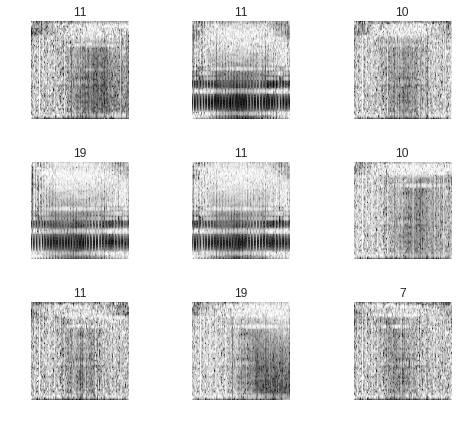

In [0]:
data.show_batch(rows=3, figsize=(7,6))

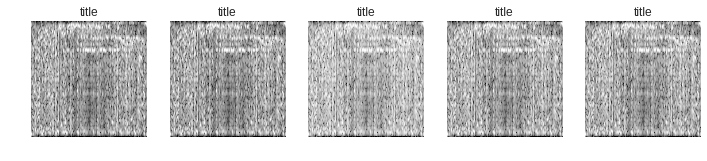

In [0]:
img_0 = data.single_ds[0][0]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    img = img_0.apply_tfms(tfms[0])
    #title = f"deg={tfm[0].resolved['degrees']:.1f}"
    img.show(ax=ax, title='title')

In [0]:
print(data.classes)
len(data.classes),data.c

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '21', '3', '4', '5', '6', '7', '8', '9']


(21, 21)

In [0]:
learn = create_cnn(data, models.resnet18, metrics=[error_rate])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.093137,4.189526,0.998656,10:06
1,2.452078,3.953797,0.912634,00:44
2,2.112814,4.080364,0.931452,00:43
3,1.894906,4.088766,0.934140,00:44


-  0.55 - 224 squish
-  0.56 - 224 pad
-  0.55 - 224 No

In [0]:
learn.save('stage-1')

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

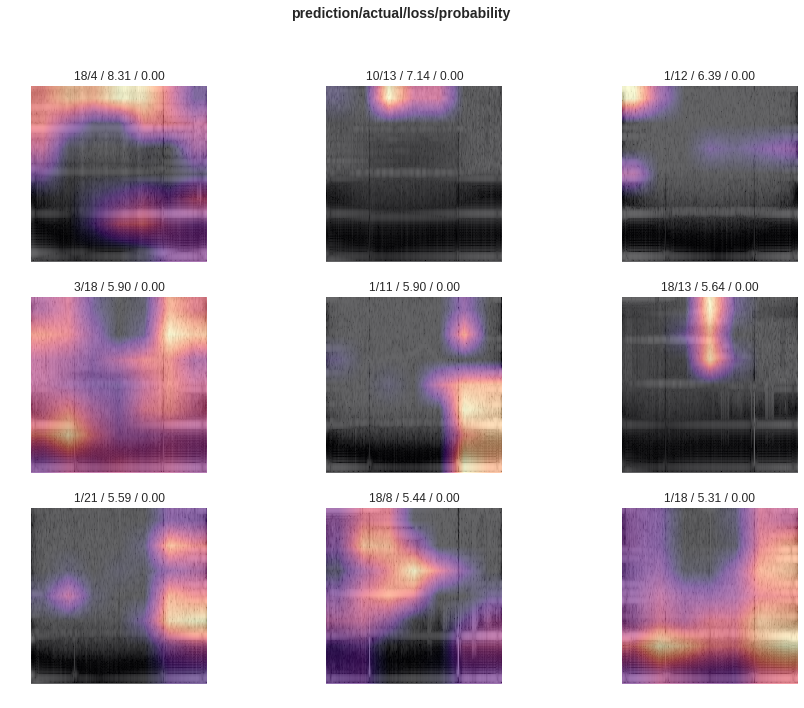

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

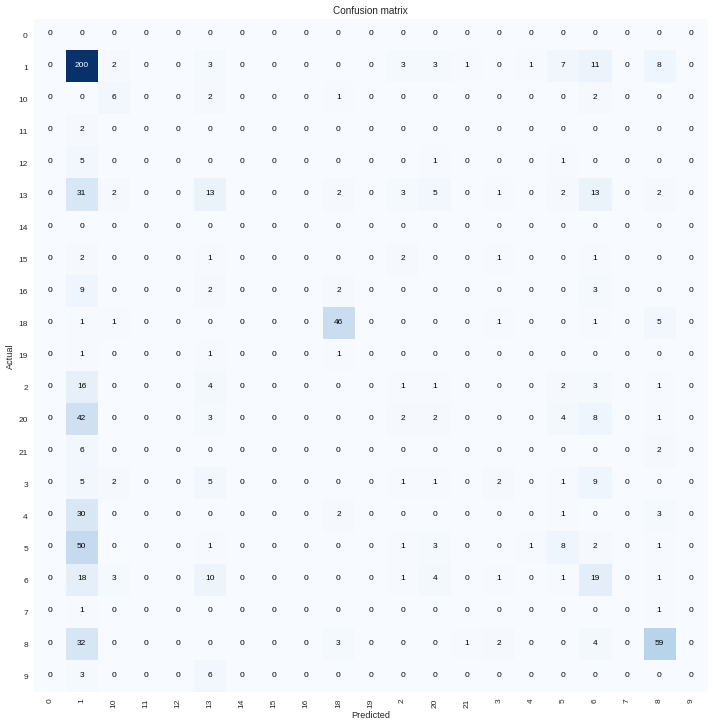

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


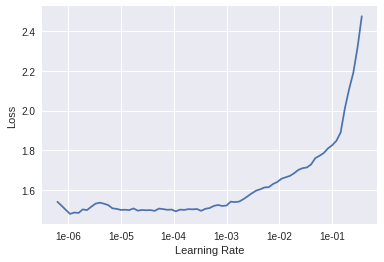

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.512268,1.800506,0.569667,00:45
1,1.412652,1.801210,0.558570,00:45


In [0]:
learn.save('u_1')

In [0]:
learn.load('u_1');

In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.362896,1.779732,0.548705,00:45
1,1.355147,1.794450,0.556104,00:45
2,1.315708,1.763167,0.537608,00:45
3,1.245360,1.743538,0.541307,00:45
4,1.158757,1.750703,0.542540,00:45
5,1.104217,1.749941,0.538841,00:45
6,1.060137,1.739259,0.542540,00:45
7,1.037426,1.746618,0.527744,00:45


In [0]:
learn.save('u_2_224')

That's a pretty accurate model!

## Full res

In [0]:
data = ImageDataBunch.from_folder(path, valid='val', ds_tfms=tfms, size=417, resize_method=ResizeMethod['NO'], bs=bs, num_workers=4).normalize(imagenet_stats)

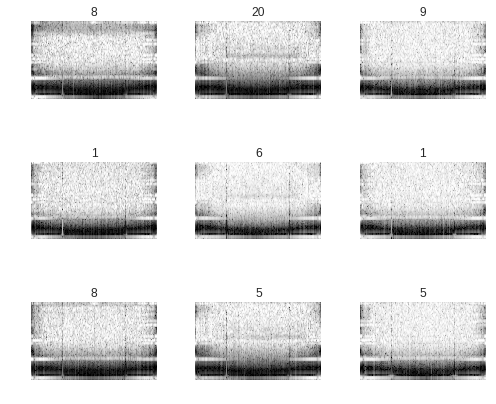

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
data.train_ds

LabelList (3171 items)
x: ImageList
Image (3, 257, 417),Image (3, 257, 417),Image (3, 257, 417),Image (3, 257, 417),Image (3, 257, 417)
y: CategoryList
20,20,20,20,20
Path: /content/gdrive/My Drive/Colab Notebooks/LIP_DS/data/images_filt

In [0]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [0]:
learn.load('u_2_224');

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.961251,1.765704,0.553638,00:48
1,1.765865,1.694763,0.532676,00:46
2,1.581975,1.650361,0.519112,00:46
3,1.419071,1.685089,0.526510,00:47


- SQUISH - 0.51-0.50
- PAD - 0.52

In [0]:
learn.save('stage-2')

### Unfreeze

In [0]:
learn.load('stage-2');

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


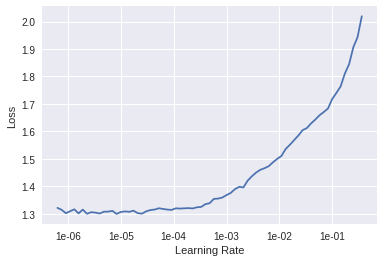

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,1.298090,1.645942,0.520345,00:57
1,1.298629,1.645492,0.525277,00:57
2,1.296873,1.616833,0.526510,00:56
3,1.290829,1.645579,0.521578,00:56
4,1.284033,1.639120,0.525277,00:56
5,1.264805,1.624015,0.531443,00:57
6,1.269187,1.634232,0.530210,00:57
7,1.254570,1.636881,0.516646,00:56


In [0]:
learn.save('u-2')

## Results

In [0]:
from sklearn.metrics import classification_report

In [0]:
preds, y = learn.get_preds()

In [0]:
preds.shape

torch.Size([811, 21])

In [0]:
preds = to_np(preds);preds.shape

(811, 21)

In [0]:
preds_c = np.argmax(preds, axis=1)

In [0]:
y = to_np(y)

In [0]:
print(classification_report(y, preds_c))

              precision    recall  f1-score   support

           1       0.47      0.77      0.59       239
           2       0.27      0.55      0.36        11
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         7
           5       0.24      0.18      0.20        74
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        16
           9       0.87      0.87      0.87        55
          10       0.00      0.00      0.00         3
          11       0.24      0.14      0.18        28
          12       0.14      0.05      0.07        62
          13       0.50      0.12      0.20         8
          14       0.00      0.00      0.00        26
          15       0.67      0.11      0.19        36
          16       0.42      0.27      0.33        67
          17       0.19      0.28      0.23        58
          18       0.00      0.00      0.00         2
          19       0.79    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


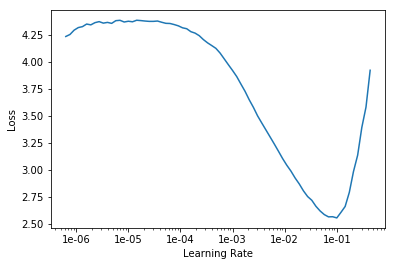

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

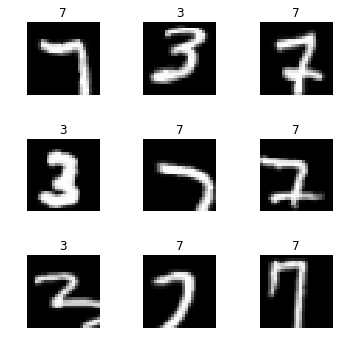

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

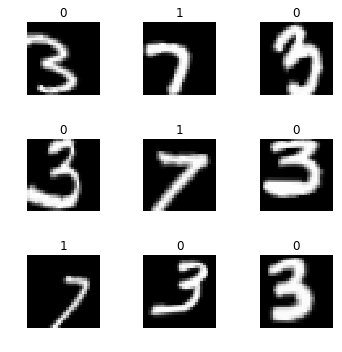

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']